In [45]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import sklearn
import pickle

from utils_ridge import (
    GD, 
    RR_SVRG, 
    RR_VR,
    L_SVRG,
    SVRG,
    RR_SGD,
    SAGA_RR,
    SAGA
)
from ridge import optimal_rigde
np.random.seed(1)
random.seed(1)

In [46]:
def load_data(path, normalize = True):
    A, y = datasets.load_svmlight_file(path)
    A = A.toarray()
    if (normalize == True):
        A = sklearn.preprocessing.normalize(A, norm="l2")
    n = A.shape[0]
    d = A.shape[1]
    return A, y, n, d

def compute_constants(A, y, n, d, lambd):
    eigvals, _ = np.linalg.eigh(np.transpose(A)@A)
    eig_max = max(eigvals)
    eig_min = min(eigvals)
    L = eig_max/n+lambd
    L_i_list = []
    for i in range(n):
        L_i_list.append(np.linalg.norm(A[i,:])**2+lambd)
    mu = eig_min/n+lambd
    L_max = max(L_i_list)
    return L, mu, L_max, L_i_list

In [47]:
algo_func_pair = {
    "L_SVRG": L_SVRG,
    "RR_SGD": RR_SGD,
    "RR_SVRG": RR_SVRG,
    "SVRG": SVRG,
    "SAGA_RR": SAGA_RR,
    "SAGA": SAGA,
    "RR_VR.9": RR_VR,
    "RR_VR.5": RR_VR,
    "RR_VR.95": RR_VR,
    "RR_VR.8": RR_VR       
}

In [62]:
algo_color_pair = {
    "L-SVRG": 'green',
    "RR": 'brown',
    "RR_SVRG": 'red',
    "SVRG": 'green',
    "SAGA_RR": 'teal',
    "SAGA": 'purple',
    "RR_VR.9": 'navy',
    "RR_VR.5": 'limegreen',
    "RR_VR.95": 'grey',
    "RR_VR.8": 'pink'          
}

In [49]:
def main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE):
    A, y, n, d = load_data(DATASET_NAME+".txt", normalize = NORMALIZE)
    if (STR_LAMBDA == '1_n'):
        lambd = 1/n
    elif (STR_LAMBDA == '10_n'):
        lambd = 10/n
    elif (STR_LAMBDA == '1_10n'):
        lambd = 1/10/n
    L, mu, L_max, L_i_list = compute_constants(A, y, n, d, lambd)
    print("n = {}, d = {}, L = {:.5f}, L_max = {:.5f}, mu = {:.5f}, kappa = {:.5f}".format(n, d, L, L_max, mu, L_max/mu))
    x_star = optimal_rigde(A, y, lambd, n, d)
    return A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star

#### Experiment #3
Comparison of theoretical SAGA-RR, RR-SVRG

Dataset: ijcnn1

Algorithms: SAGA_RR, RR_SVRG

In [50]:
def myMain(algo_name, A, y, lambd, n, d, stepsize, x_star, iter_num = 100):
    if (algo_name == "RR_VR.9"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.9, max_num_iter = iter_num)        
    if (algo_name == "RR_VR.8"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.8, max_num_iter = iter_num)
    if (algo_name == "RR_VR.5"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.5, max_num_iter = iter_num)    
    return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, max_num_iter = iter_num)

In [51]:
algos = ['SAGA_RR', 'RR_SVRG']
DATASET_NAME = "ijcnn1"
NORMALIZE = True
STR_LAMBDA = '1_n'

In [52]:
A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 35000, d = 22, L = 0.11453, L_max = 1.00003, mu = 0.00218, kappa = 459.70317


In [38]:
# stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
# STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [39]:
number_of_experiments = 1
number_of_epochs = 100
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
#         for stepsize in stepsizes:
        if (algo == 'SAGA_RR'):
            stepsize = mu/L/L/n/11
        elif (algo == 'RR_SVRG'):
            if (n >= 2*L/mu/(1-mu/2**0.5/L)):
                print('big data')
                stepsize = 1/2**0.5/L/n
            else:
                print('small data')
                stepsize = 1/2**0.5/L/n/2*(mu/L)**0.5
        np.random.seed(experiment)
        random.seed(experiment)
        alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                             n, d, stepsize, x_star, iter_num = number_of_epochs)
        print(alg_error[-1])
        if (best_error > alg_error[-1]):
                best_error = alg_error[-1].copy()
                best_errors = alg_error.copy()
                best_grads = alg_grad.copy()
                best_epochs = alg_epochs.copy()
                best_grad_comps = alg_grad_comps.copy()
                print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)

SAGA_RR
0.8669719118793808
4.3072704884635906e-07 SAGA_RR
RR_SVRG
big data
0.010256653391202165
0.0001763928344494548 RR_SVRG


In [43]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

SAGA_RR
RR_SVRG


In [53]:
def plot_results(results, xlim = 50, ylim = 1e-15, save = False, filename = "test.pdf"):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    for algo in algos:
        if (algo == 'SAGA_RR'):
            label = 'RR_SAGA'
        if (algo == 'RR_SVRG'):
            label = 'Rand-Reshuffle'
        plt.plot(results[algo]['grad_comps'][0], error_best[algo], label = label, marker='*', color = algo_color_pair[algo])
    plt.xlim(0, xlim)
    plt.title(r"$n={}, \kappa={:.0f} $".format(n, L_max//mu), fontsize=BIGGER_SIZE)
    plt.xlabel("#gradients/n", fontsize = BIGGER_SIZE)
    plt.ylabel(r"$||x_k-x_*||^2$", fontsize = BIGGER_SIZE)
    plt.ylim(ylim, 2)
    plt.legend(fontsize = BIGGER_SIZE)
    plt.grid()
    if save:
        plt.savefig("plots/"+filename, dpi=500, bbox_inches='tight')
    plt.show()
    

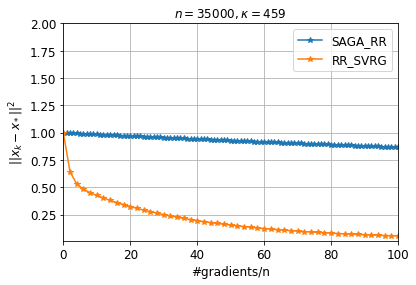

In [47]:
plot_results(results, xlim = 100, ylim = 0.01)

In [50]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "ridge",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": "theoretical"
}
name = 'ridge_saga_svrg_theoretical_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

ridge_saga_svrg_theoretical_ijcnn1_normalized_lambd_1_n


In [54]:
name = 'ridge_saga_svrg_theoretical_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)
in_pickle = pickle.load(open("plots/"+name+'.pickle', "rb" ))
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*in_pickle["results"][algo]['error'])]
    error_best[algo] = min(in_pickle["results"][algo]['error'], key=lambda x: x[-1])

ridge_saga_svrg_theoretical_ijcnn1_normalized_lambd_1_n
SAGA_RR
RR_SVRG


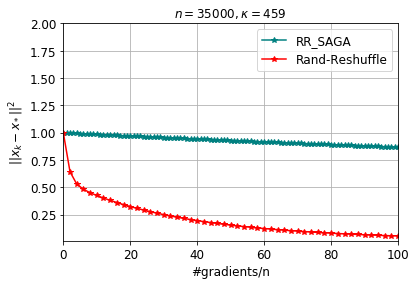

In [64]:
plot_results(in_pickle['results'], xlim = 100, ylim = 0.01, filename=name+'neurips.pdf', save=True)

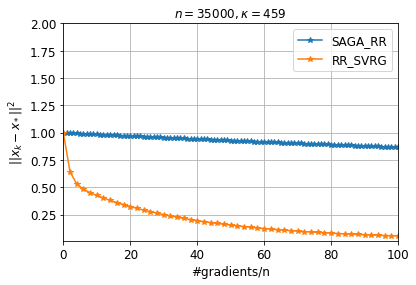

In [51]:
# plot_results(results, xlim = 100, ylim = 0.01, filename=name+'.pdf', save=True)

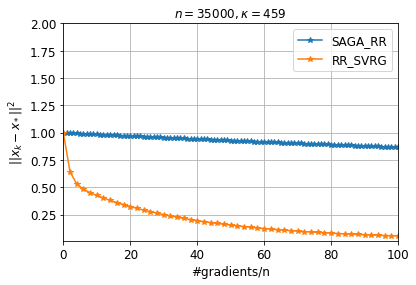

In [52]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### 2nd plot

In [65]:
algos = ['SAGA_RR', 'RR_SVRG']
DATASET_NAME = "phishing"
NORMALIZE = True
STR_LAMBDA = '1_n'

In [66]:
A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

FileNotFoundError: [Errno 2] No such file or directory: 'phishing.txt'

In [65]:
number_of_experiments = 1
number_of_epochs = 50
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
#         for stepsize in stepsizes:
        if (algo == 'SAGA_RR'):
            stepsize = mu/L/L/n/11
        elif (algo == 'RR_SVRG'):
            if (n >= 2*L/mu/(1-mu/2**0.5/L)):
                print('big data')
                stepsize = 1/2**0.5/L/n
            else:
                print('small data')
                stepsize = 1/2**0.5/L/n/2*(mu/L)**0.5
        np.random.seed(experiment)
        random.seed(experiment)
        alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                             n, d, stepsize, x_star, iter_num = number_of_epochs)
        print(alg_error[-1])
        if (best_error > alg_error[-1]):
                best_error = alg_error[-1].copy()
                best_errors = alg_error.copy()
                best_grads = alg_grad.copy()
                best_epochs = alg_epochs.copy()
                best_grad_comps = alg_grad_comps.copy()
                print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)

SAGA_RR
0.9992793083235662
1.7588527660527507e-09 SAGA_RR
RR_SVRG
small data
0.8064742220697231
5.799915081293233e-07 RR_SVRG


In [66]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

SAGA_RR
RR_SVRG


In [110]:
def plot_results(results, xlim = 50, ylim = 1e-15, save = False, filename = "test.pdf"):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    for algo in algos:
        plt.plot(results[algo]['grad_comps'][0], error_best[algo], label = algo, marker='*')
    plt.xlim(0, xlim)
    plt.title(r"$n={}, \kappa={:.0f} $".format(n, L_max//mu), fontsize=BIGGER_SIZE)
    plt.xlabel("#gradients/n", fontsize = BIGGER_SIZE)
    plt.ylabel(r"$||x_k-x_*||^2$", fontsize = BIGGER_SIZE)
    plt.ylim(ylim, 1.01)
    plt.legend(fontsize = BIGGER_SIZE)
    plt.grid()
    if save:
        plt.savefig("plots/"+filename, dpi=500, bbox_inches='tight')
    plt.show()

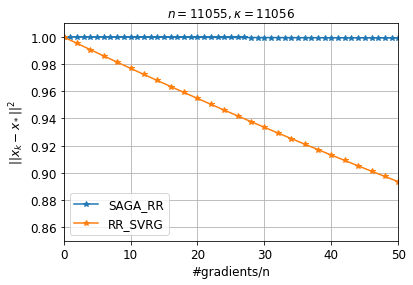

In [111]:
plot_results(results, xlim=50, ylim=0.85)

In [112]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "ridge",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": "theoretical"
}
name = 'ridge_saga_svrg_theoretical_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

ridge_saga_svrg_theoretical_phishing_normalized_lambd_1_n


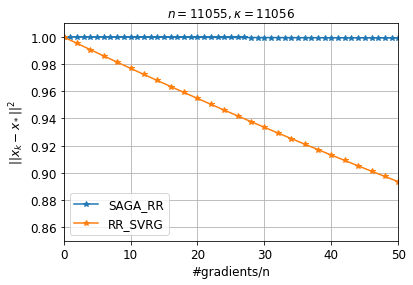

In [113]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)
# plot_results(results, xlim=50, ylim=0.85, filename=name+'.pdf', save=True)  

#### 3rd plot

In [67]:
algos = ['SAGA_RR', 'RR_SVRG']
DATASET_NAME = "a7a"
NORMALIZE = True
STR_LAMBDA = '10_n'

In [68]:
A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 16100, d = 122, L = 0.45368, L_max = 1.00062, mu = 0.00062, kappa = 1611.00000


In [26]:
number_of_experiments = 1
number_of_epochs = 50
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
#         for stepsize in stepsizes:
        if (algo == 'SAGA_RR'):
            stepsize = mu/L/L/n/11
        elif (algo == 'RR_SVRG'):
            if (n >= 2*L/mu/(1-mu/2**0.5/L)):
                print('big data')
                stepsize = 1/2**0.5/L/n
            else:
                print('small data')
                stepsize = 1/2**0.5/L/n/2*(mu/L)**0.5
        np.random.seed(experiment)
        random.seed(experiment)
        alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                             n, d, stepsize, x_star, iter_num = number_of_epochs)
        print(alg_error[-1])
        if (best_error > alg_error[-1]):
                best_error = alg_error[-1].copy()
                best_errors = alg_error.copy()
                best_grads = alg_grad.copy()
                best_epochs = alg_epochs.copy()
                best_grad_comps = alg_grad_comps.copy()
                print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)

SAGA_RR
0.9964855743174257
1.7039735640912794e-08 SAGA_RR
RR_SVRG
big data
0.500136156422434
9.680833952972805e-05 RR_SVRG


In [27]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

SAGA_RR
RR_SVRG


In [69]:
def plot_results(results, xlim = 50, ylim = 1e-15, save = False, filename = "test.pdf"):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    for algo in algos:
        if (algo == 'SAGA_RR'):
            label = 'RR_SAGA'
        if (algo == 'RR_SVRG'):
            label = 'Rand-Reshuffle'        
        plt.plot(results[algo]['grad_comps'][0], error_best[algo], label = label, marker='*', color = algo_color_pair[algo])
    plt.xlim(0, xlim)
    plt.title(r"$n={}, \kappa={:.0f} $".format(n, L_max//mu), fontsize=BIGGER_SIZE)
    plt.xlabel("#gradients/n", fontsize = BIGGER_SIZE)
    plt.ylabel(r"$||x_k-x_*||^2$", fontsize = BIGGER_SIZE)
    plt.ylim(ylim, 1.01)
    plt.legend(fontsize = BIGGER_SIZE)
    plt.grid()
    if save:
        plt.savefig("plots/"+filename, dpi=500, bbox_inches='tight')
    plt.show()

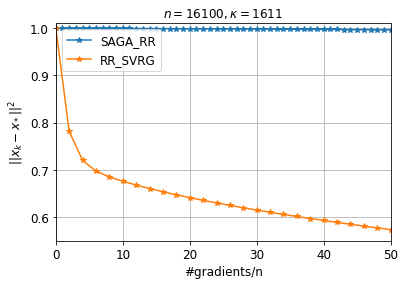

In [33]:
plot_results(results, xlim=50, ylim=0.55)

In [35]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "ridge",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": "theoretical"
}


ridge_saga_svrg_theoretical_a7a_normalized_lambd_10_n


In [53]:
name = 'ridge_saga_svrg_theoretical_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

ridge_saga_svrg_theoretical_a7a_normalized_lambd_10_n


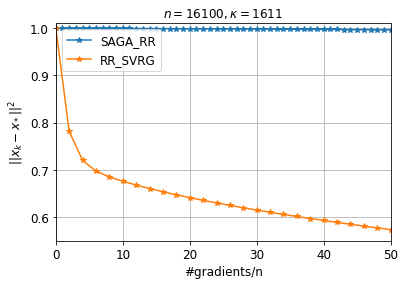

In [34]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)
# plot_results(results, xlim=50, ylim=0.55, filename=name+'.pdf', save=True)  

In [70]:
name = 'ridge_saga_svrg_theoretical_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)
in_pickle = pickle.load(open("plots/"+name+'.pickle', "rb" ))
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*in_pickle["results"][algo]['error'])]
    error_best[algo] = min(in_pickle["results"][algo]['error'], key=lambda x: x[-1])

ridge_saga_svrg_theoretical_a7a_normalized_lambd_10_n
SAGA_RR
RR_SVRG


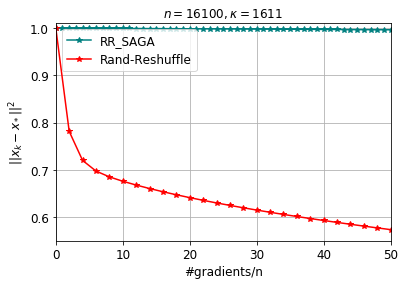

In [71]:
plot_results(in_pickle['results'], xlim=50, ylim=0.55)

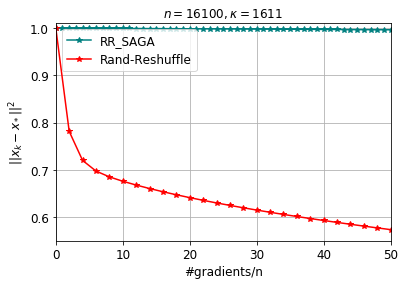

In [72]:
plot_results(in_pickle['results'], xlim=50, ylim=0.55, filename=name+'neurips.pdf', save=True)  

#### 4th plot

In [73]:
algos = ['SAGA_RR', 'RR_SVRG']
DATASET_NAME = "bodyfat"
NORMALIZE = True
STR_LAMBDA = '1_n'

In [74]:
A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 252, d = 14, L = 0.99804, L_max = 1.00397, mu = 0.00397, kappa = 252.80584


In [49]:
number_of_experiments = 1
number_of_epochs = 200
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
#         for stepsize in stepsizes:
        if (algo == 'SAGA_RR'):
            stepsize = mu/L/L/n/11
        elif (algo == 'RR_SVRG'):
            if (n >= 2*L/mu/(1-mu/2**0.5/L)):
                print('big data')
                stepsize = 1/2**0.5/L/n
            else:
                print('small data')
                stepsize = 1/2**0.5/L/n/2*(mu/L)**0.5
        np.random.seed(experiment)
        random.seed(experiment)
        alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                             n, d, stepsize, x_star, iter_num = number_of_epochs)
        print(alg_error[-1])
        if (best_error > alg_error[-1]):
                best_error = alg_error[-1].copy()
                best_errors = alg_error.copy()
                best_grads = alg_grad.copy()
                best_epochs = alg_epochs.copy()
                best_grad_comps = alg_grad_comps.copy()
                print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)

SAGA_RR
0.9377321393886593
1.4382777960656925e-06 SAGA_RR
RR_SVRG
small data
0.5188311634448523
8.867439801172216e-05 RR_SVRG


In [50]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

SAGA_RR
RR_SVRG


In [75]:
def plot_results(results, xlim = 50, ylim = 1e-15, save = False, filename = "test.pdf"):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    for algo in algos:
        if (algo == 'SAGA_RR'):
            label = 'RR_SAGA'
        if (algo == 'RR_SVRG'):
            label = 'Rand-Reshuffle'          
        plt.plot(results[algo]['grad_comps'][0], error_best[algo], label = label, marker='*', color=algo_color_pair[algo])
    plt.xlim(0, xlim)
    plt.title(r"$n={}, \kappa={:.0f} $".format(n, L_max//mu), fontsize=BIGGER_SIZE)
    plt.xlabel("#gradients/n", fontsize = BIGGER_SIZE)
    plt.ylabel(r"$||x_k-x_*||^2$", fontsize = BIGGER_SIZE)
    plt.ylim(ylim, 1.01)
    plt.legend(fontsize = BIGGER_SIZE)
    plt.grid()
    if save:
        plt.savefig("plots/"+filename, dpi=500, bbox_inches='tight')
    plt.show()

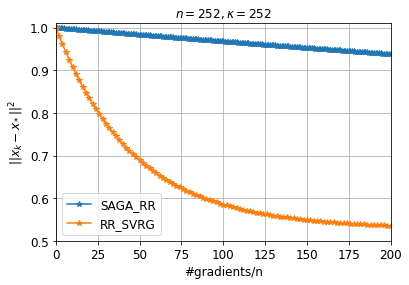

In [53]:
plot_results(results, xlim=200, ylim=0.5)

In [54]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "ridge",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": "theoretical"
}

ridge_saga_svrg_theoretical_bodyfat_normalized_lambd_1_n


In [63]:
name = 'ridge_saga_svrg_theoretical_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

ridge_saga_svrg_theoretical_bodyfat_normalized_lambd_1_n


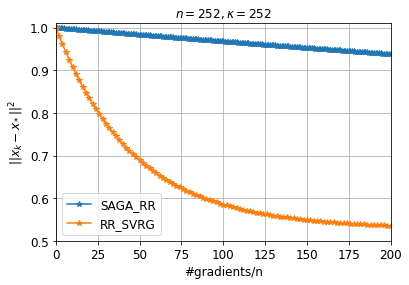

In [55]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)
# plot_results(results, xlim=200, ylim=0.5, filename=name+'.pdf', save=True)  

In [76]:
name = 'ridge_saga_svrg_theoretical_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)
in_pickle = pickle.load(open("plots/"+name+'.pickle', "rb" ))
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*in_pickle["results"][algo]['error'])]
    error_best[algo] = min(in_pickle["results"][algo]['error'], key=lambda x: x[-1])

ridge_saga_svrg_theoretical_bodyfat_normalized_lambd_1_n
SAGA_RR
RR_SVRG


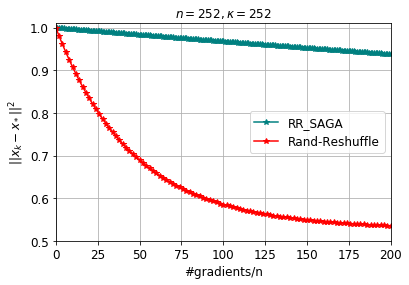

In [78]:
plot_results(in_pickle['results'], xlim=200, ylim=0.5, filename=name+'neurips.pdf', save=True)  